
# Team 7 — Gender Discrimination Lawsuit (Surgery Department)
**Name:** Zhang Jianyu  
**Goal:** Reproduce an end-to-end analysis for the Surgery department (Dept=6), including EDA, statistical tests, and models (OLS & Logistic)

**Inputs**  
- `Lawsuit.csv` 

**Outputs**  
- Tables (CSV): summary counts/means, test statistics, OLS/Logit coefficients, model overview  
- Charts (PNG): gender×rank bar chart, Sal95 boxplot by gender, experience vs salary scatter with OLS lines  


In [1]:
# 1) Imports & configuration
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
import patsy as pt

# Configuration
BASE_DIR = Path.cwd()

DATA_PATH = BASE_DIR / "Lawsuit.csv"     # input data path
OUTPUT_DIR = BASE_DIR / "outputs"        # all CSV/PNG will be saved here

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


# Utility helpers
def ensure_output_dir(path: str) -> None:
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

def save_df(df: pd.DataFrame, filename: str) -> str:
    fp = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(fp, index=False)
    print(f"[Saved] {fp}")
    return fp

def save_fig(fig, filename: str) -> str:
    fp = os.path.join(OUTPUT_DIR, filename)
    fig.canvas.draw()                      
    fig.savefig(fp, bbox_inches="tight")   
    plt.close(fig)                         
    print(f"[Saved] {fp}")
    return fp

ensure_output_dir(OUTPUT_DIR)


ModuleNotFoundError: No module named 'statsmodels'


## 1. Load data
We load the full dataset and filter to the **Surgery** department (`Dept == 6`).  
We also map codes into human-readable labels for presentation.


In [15]:
# Load the data
df = pd.read_csv(DATA_PATH)

# Filter to Surgery (Dept == 6)
surg = df[df["Dept"] == 6].copy()

# Mapping dictionaries
gender_map = {1: "Male", 0: "Female"}
rank_map   = {1: "Assistant", 2: "Associate", 3: "Full"}
clin_map   = {1: "Clinical", 0: "Research"}
cert_map   = {1: "Certified", 0: "Not Certified"}

# Apply mappings for readability
surg["Gender_label"] = surg["Gender"].map(gender_map)
surg["Rank_label"]   = surg["Rank"].map(rank_map)
surg["Clin_label"]   = surg["Clin"].map(clin_map)
surg["Cert_label"]   = surg["Cert"].map(cert_map)

# Quick schema check
schema = pd.DataFrame({
    "column": surg.columns,
    "dtype": [str(t) for t in surg.dtypes],
    "non_null": surg.notna().sum(),
    "nulls": surg.isna().sum()
})
schema.head(20)


,column,dtype,non_null,nulls
ID,ID,int64,40,0
Dept,Dept,int64,40,0
Gender,Gender,int64,40,0
Clin,Clin,int64,40,0
Cert,Cert,int64,40,0
Prate,Prate,float64,40,0
Exper,Exper,int64,40,0
Rank,Rank,int64,40,0
Sal94,Sal94,int64,40,0
Sal95,Sal95,int64,40,0



## 2. Exploratory Data Analysis (EDA)
Basic counts and group-wise means to understand the department-level structure.


In [16]:
# Counts by gender and rank
summary_counts = surg.groupby("Gender_label").agg(
    n=("Gender", "size"),
    rank_full=("Rank", lambda s: int((s == 3).sum())),
    rank_assoc=("Rank", lambda s: int((s == 2).sum())),
    rank_asst=("Rank", lambda s: int((s == 1).sum())),
).reset_index()

# Means for core metrics
salary_means = surg.groupby("Gender_label").agg(
    Sal94_mean=("Sal94","mean"),
    Sal95_mean=("Sal95","mean"),
    Exper_mean=("Exper","mean"),
    Prate_mean=("Prate","mean")
).round(3).reset_index()

summary_counts, salary_means


(  Gender_label   n  rank_full  rank_assoc  rank_asst
 0       Female   5          1           1          3
 1         Male  35         11           8         16,
   Gender_label  Sal94_mean  Sal95_mean  Exper_mean  Prate_mean
 0       Female  254375.200  280869.400       6.400        2.78
 1         Male  294489.486  324696.371      11.257        2.60)

In [17]:
# Save EDA tables
save_df(summary_counts, "surgery_summary_counts.csv")
save_df(salary_means, "surgery_salary_means.csv")


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_summary_counts.csv
[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_salary_means.csv


'c:\\Users\\Zhang\\OneDrive - Nanyang Technological University\\桌面\\NTU学习\\AN6003 Course Materials\\AN6003 Course Materials\\Graded Team Assignment - Gender Discrimination Lawsuit\\AN6003_GradedTeamAssignment\\outputs\\surgery_salary_means.csv'

## 3. Models
We use **OLS** for continuous outcomes and **Logistic regression** for multiclass.  
Unless noted, covariates are the same across models: `Exper`, `Prate`, `C(Cert)`, `C(Clin)`, `C(Rank)`.

### 3.1 OLS — Salary Levels (continuous)
Two comparable level models for 1994 and 1995:
```
Sal94 \~ C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)
Sal95 \~ C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)
```

**Interpretation：** `C(Gender)[T.1]` is the adjusted mean pay difference for **Male vs Female**, holding other factors constant.  
**Why both years?** `Sal94` provides a robustness check; `Sal95` is the most recent level at the time.

In [18]:
ols94_formula = "Sal94 ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)"
ols94_model = smf.ols(ols94_formula, data=surg).fit()

# Coefficient table (rounded) for reporting
ols94_coefs = ols94_model.summary2().tables[1].reset_index().rename(columns={"index": "term"})
for col in ["Coef.", "Std.Err.", "t", "P>|t|", "[0.025", "0.975]"]:
    if col in ols94_coefs.columns:
        ols94_coefs[col] = ols94_coefs[col].astype(float).round(4)

# Compact model overview
ols94_overview = pd.DataFrame({
    "R_squared":      [round(ols94_model.rsquared, 4)],
    "Adj_R_squared":  [round(ols94_model.rsquared_adj, 4)],
    "N":              [int(ols94_model.nobs)]
})

ols94_overview, ols94_coefs.head(10)


(   R_squared  Adj_R_squared   N
 0     0.7638         0.7122  40,
              term       Coef.    Std.Err.       t   P>|t|      [0.025  \
 0       Intercept  88337.7304  83138.2027  1.0625  0.2959 -81009.2467   
 1  C(Gender)[T.1]  11967.9889  17773.7049  0.6734  0.5056 -24235.8632   
 2    C(Cert)[T.1]  51394.2998  26085.8855  1.9702  0.0575  -1740.9102   
 3    C(Clin)[T.1]  62152.7829  45266.8334  1.3730  0.1793 -30052.7394   
 4    C(Rank)[T.2]  39457.4164  15525.3620  2.5415  0.0161   7833.2888   
 5    C(Rank)[T.3]  66721.6904  15621.1817  4.2712  0.0002  34902.3845   
 6           Exper   4956.7938   1147.5652  4.3194  0.0001   2619.2799   
 7           Prate   -168.6744  13219.2352 -0.0128  0.9899 -27095.3753   
 
         0.975]  
 0  257684.7076  
 1   48171.8411  
 2  104529.5099  
 3  154358.3052  
 4   71081.5440  
 5   98540.9963  
 6    7294.3077  
 7   26758.0266  )

In [19]:
# OLS model
ols_formula = "Sal95 ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)"
ols_model = smf.ols(ols_formula, data=surg).fit()

ols_coefs = ols_model.summary2().tables[1].reset_index().rename(columns={"index":"term"})
for col in ["Coef.","Std.Err.","t","P>|t|","[0.025","0.975]"]:
    if col in ols_coefs.columns:
        ols_coefs[col] = ols_coefs[col].astype(float).round(4)

ols_overview = pd.DataFrame({
    "R_squared":[round(ols_model.rsquared,4)],
    "Adj_R_squared":[round(ols_model.rsquared_adj,4)],
    "N":[int(ols_model.nobs)]
})

ols_overview, ols_coefs.head(10)


(   R_squared  Adj_R_squared   N
 0     0.7656         0.7143  40,
              term       Coef.    Std.Err.       t   P>|t|      [0.025  \
 0       Intercept  90439.2729  91547.0729  0.9879  0.3306 -96036.0124   
 1  C(Gender)[T.1]  13476.6195  19571.3957  0.6886  0.4960 -26389.0090   
 2    C(Cert)[T.1]  59403.2186  28724.2975  2.0680  0.0468    893.7393   
 3    C(Clin)[T.1]  69106.5712  49845.2693  1.3864  0.1752 -32424.9198   
 4    C(Rank)[T.2]  39660.1756  17095.6480  2.3199  0.0269   4837.4802   
 5    C(Rank)[T.3]  74544.2072  17201.1592  4.3337  0.0001  39506.5924   
 6           Exper   5424.8248   1263.6337  4.2930  0.0002   2850.8871   
 7           Prate   1568.5547  14556.2720  0.1078  0.9149 -28081.6011   
 
         0.975]  
 0  276914.5582  
 1   53342.2479  
 2  117912.6978  
 3  170638.0622  
 4   74482.8711  
 5  109581.8219  
 6    7998.7625  
 7   31218.7104  )

### 3.1 Results — OLS on Salary Levels (Sal94 & Sal95)

**Model spec (both years):**  
`SalYY ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)`  
N = 40. `C(Gender)[T.1]` = Male vs Female (Female is the reference).

**Sal94 (1994 pay)**
- Fit: **R² = 0.764**, Adj. R² = 0.712.  
- **Gender (Male vs Female): +$11.97k, p = 0.506 → not significant.**
- **Rank**: Associate **+$39.46k (p = 0.016)**; Full **+$66.72k (p < 0.001)**.
- **Experience**: **+$4.96k per year (p < 0.001)**.
- **Certification**: +$51.39k, **p = 0.058** (borderline).  
- **Clin vs Research**: +$62.15k, p = 0.179 (n.s.).  
- **Publication rate**: –$0.17k, p = 0.990 (n.s.).

**Sal95 (1995 pay)**
- Fit: **R² = 0.766**, Adj. R² = 0.714.  
- **Gender (Male vs Female): +$13.48k, p = 0.496 → not significant.**
- **Rank**: Associate **+$39.66k (p = 0.027)**; Full **+$74.54k (p < 0.001)**.
- **Experience**: **+$5.42k per year (p < 0.001)**.
- **Certification**: **+$59.40k (p = 0.047)** — significant in 1995.  
- **Clin vs Research**: +$69.11k, p = 0.175 (n.s.).  
- **Publication rate**: +$1.57k, p = 0.915 (n.s.).

**Takeaways (within-rank, within-credentials)**
- After controlling for **rank, experience, certification, track, and publication rate**, the **gender coefficient is positive but not statistically significant** in both years → **no within-rank pay gap detected at conventional levels** (power is limited; female n is small).
- **Rank and experience** are the strongest pay drivers; **certification** also matters (significant in 1995, borderline in 1994).
- Combined with our **promotion model (Logit)** showing women are less likely to be **Full Professors**, the evidence suggests the inequity in Surgery is driven **more by rank composition (who reaches Full)** than by **within-rank salary differences**.

### 3.2 Logistic Regression 
**Binary comparisons to cover all rank transitions.**
We estimate three logistic models so that each key transition is tested with course-taught binary logit:

- **3.2a Senior vs Assistant**: `Senior = 1{Rank ≥ 2}` — reaching at least Associate.
- **3.2b Associate vs Assistant**: restricted to non-Full sample — the lower-to-middle step.
- **3.2c FullProf vs Others**: FullProf = 1 if Rank == 3 else 0

For each model, report the **odds ratio (OR)** and p-value for `C(Gender)[T.1]` (Male vs Female), plus 95% CI.
If a convergence warning appears (small n / sparse cells), note it and interpret conservatively.

In [20]:
# 3.2a) Logistic — Senior (Associate or Full) vs Assistant
# Purpose: test whether men have higher odds to reach at least Associate.

# Helper: fit logit and export an OR table
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def fit_logit_and_export(formula: str, df: pd.DataFrame, name_prefix: str):
    """Fit a logistic regression and export an OR table (rounded) for slides."""
    try:
        model = smf.logit(formula, data=df).fit(disp=False, maxiter=200)
        used_spec = "full"
    except PerfectSeparationError:
        print("[PerfectSeparationError] Dropping C(Clin) and C(Cert) for stability.")
        reduced = formula.replace("+ C(Cert) + C(Clin)", "")
        model = smf.logit(reduced, data=df).fit(disp=False, maxiter=200)
        used_spec = "reduced"
    except Exception as e:
        print(f"[Fallback due to {type(e).__name__}] Trying reduced spec.")
        reduced = formula.replace("+ C(Cert) + C(Clin)", "")
        model = smf.logit(reduced, data=df).fit(disp=False, maxiter=200)
        used_spec = "reduced"

    coefs = model.summary2().tables[1].reset_index().rename(columns={"index":"term"})
    if "Coef." in coefs.columns:
        coefs["Odds_Ratio"] = np.exp(coefs["Coef."])
    for col in ["Coef.","Std.Err.","z","P>|z|","[0.025","0.975]","Odds_Ratio"]:
        if col in coefs.columns:
            coefs[col] = coefs[col].astype(float).round(4)

    print(f"[Spec used: {used_spec}]")
    display(coefs.head(10))
    save_df(coefs, f"{name_prefix}_coef_table.csv")
    return model, coefs

# Build target and fit
surg = surg.assign(Senior=(surg["Rank"] >= 2).astype(int))
logit_senior_formula = "Senior ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin)"
logit_senior_model, logit_senior_coefs = fit_logit_and_export(
    logit_senior_formula, surg, "surgery_logit_senior"
)

[Fallback due to LinAlgError] Trying reduced spec.
[Spec used: reduced]


,term,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Odds_Ratio
0,Intercept,-2.8397,2.2884,-1.2409,0.2146,-7.3249,1.6455,0.0584
1,C(Gender)[T.1],-0.4108,1.0906,-0.3767,0.7064,-2.5485,1.7268,0.6631
2,Exper,0.2764,0.1000,2.7637,0.0057,0.0804,0.4724,1.3184
3,Prate,0.2132,0.7310,0.2916,0.7706,-1.2196,1.6459,1.2376


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_logit_senior_coef_table.csv


In [21]:
# 3.2b) Logistic — Associate vs Assistant (restricted to non-Full)
# Purpose: test the lower-to-middle step excluding Fulls (helps reduce separation).

surg_nonfull = surg[surg["Rank"] < 3].copy()
surg_nonfull["Associate"] = (surg_nonfull["Rank"] == 2).astype(int)

logit_assoc_formula = "Associate ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin)"
logit_assoc_model, logit_assoc_coefs = fit_logit_and_export(
    logit_assoc_formula, surg_nonfull, "surgery_logit_associate"
)

[Fallback due to LinAlgError] Trying reduced spec.
[Spec used: reduced]


,term,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Odds_Ratio
0,Intercept,-3.1020,2.5043,-1.2387,0.2155,-8.0104,1.8064,0.0450
1,C(Gender)[T.1],-0.2802,1.3518,-0.2073,0.8358,-2.9297,2.3692,0.7556
2,Exper,0.2069,0.1062,1.9476,0.0515,-0.0013,0.4151,1.2299
3,Prate,0.2605,0.7669,0.3397,0.7341,-1.2426,1.7636,1.2976


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_logit_associate_coef_table.csv


In [22]:
# 3.2c) Logistic — FullProf vs Others
surg = surg.assign(FullProf=(surg["Rank"] == 3).astype(int))
logit_formula = "FullProf ~ C(Gender) + Exper + Prate + C(Cert) + C(Clin)"
logit_model = smf.logit(logit_formula, data=surg).fit(disp=False)

logit_coefs = logit_model.summary2().tables[1].reset_index().rename(columns={"index":"term"})
if "Coef." in logit_coefs.columns:
    logit_coefs["Odds_Ratio"] = np.exp(logit_coefs["Coef."])
for col in ["Coef.","Std.Err.","z","P>|z|","[0.025","0.975]","Odds_Ratio"]:
    if col in logit_coefs.columns:
        logit_coefs[col] = logit_coefs[col].astype(float).round(4)

logit_coefs.head(10)


c:\Users\Zhang\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,term,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Odds_Ratio
0,Intercept,-46.1852,402783.1069,-0.0001,0.9999,-789486.5682,789394.1979,0.000000e+00
1,C(Gender)[T.1],-0.2383,1.3091,-0.1820,0.8556,-2.8040,2.3275,7.880000e-01
2,C(Cert)[T.1],26.5474,402782.0949,0.0001,0.9999,-789411.8522,789464.9470,3.383607e+11
3,C(Clin)[T.1],14.2912,902.5994,0.0158,0.9874,-1754.7712,1783.3536,1.609083e+06
4,Exper,0.2283,0.0876,2.6075,0.0091,0.0567,0.3999,1.256500e+00
5,Prate,0.8532,1.0508,0.8120,0.4168,-1.2062,2.9127,2.347200e+00


In [23]:
# === Summarize binary promotion models (3.2a / 3.2b / 3.2c) ===
def _find_ci_cols(df):
    """Find the names of the two CI columns in statsmodels table."""
    low_candidates  = [c for c in df.columns if c.startswith("[0.025")]
    high_candidates = [c for c in df.columns if c.endswith("0.975]") or c=="0.975]"]
    # Fallbacks (some tables use exact '[0.025' and '0.975]')
    if not low_candidates:
        low_candidates = [c for c in df.columns if c.strip().startswith("[0.025")]
    if not high_candidates:
        high_candidates = [c for c in df.columns if c.strip().endswith("0.975]")]
    low  = low_candidates[0]  if low_candidates  else None
    high = high_candidates[0] if high_candidates else None
    return low, high

def extract_row(df, term_name):
    """Return a dict with OR, p, OR_CI_low, OR_CI_high for a given term."""
    row = df.loc[df["term"] == term_name]
    if row.empty:
        return dict(OR=np.nan, p=np.nan, OR_low=np.nan, OR_high=np.nan)
    low_col, high_col = _find_ci_cols(df)
    # Odds Ratio already provided; CI columns are log-odds, need exp()
    OR      = float(row["Odds_Ratio"])
    p       = float(row[row.columns[row.columns.str.contains(r"P>\|z\|")][0]])
    OR_low  = float(np.exp(row[low_col]))  if low_col  in row else np.nan
    OR_high = float(np.exp(row[high_col])) if high_col in row else np.nan
    return dict(OR=round(OR,4), p=round(p,4), OR_low=round(OR_low,4), OR_high=round(OR_high,4))

def one_line(model_name, gender_dict, exper_dict):
    g = gender_dict; e = exper_dict
    print(f"[{model_name}] Gender(Male vs Female): OR={g['OR']}, p={g['p']} "
          f"(95% CI {g['OR_low']}, {g['OR_high']}); "
          f"Experience: OR={e['OR']}, p={e['p']} (95% CI {e['OR_low']}, {e['OR_high']})")

summary_rows = []

# 3.2a Senior (≥Associate) vs Assistant
g_a = extract_row(logit_senior_coefs, "C(Gender)[T.1]")
e_a = extract_row(logit_senior_coefs, "Exper")
one_line("3.2a Senior vs Assistant", g_a, e_a)
summary_rows.append({"Model":"3.2a Senior vs Assistant",
                     "Gender_OR":g_a["OR"], "Gender_p":g_a["p"],
                     "Gender_CI_low":g_a["OR_low"], "Gender_CI_high":g_a["OR_high"],
                     "Exper_OR":e_a["OR"], "Exper_p":e_a["p"]})

# 3.2b Associate vs Assistant (non-Full)
g_b = extract_row(logit_assoc_coefs, "C(Gender)[T.1]")
e_b = extract_row(logit_assoc_coefs, "Exper")
one_line("3.2b Associate vs Assistant", g_b, e_b)
summary_rows.append({"Model":"3.2b Associate vs Assistant",
                     "Gender_OR":g_b["OR"], "Gender_p":g_b["p"],
                     "Gender_CI_low":g_b["OR_low"], "Gender_CI_high":g_b["OR_high"],
                     "Exper_OR":e_b["OR"], "Exper_p":e_b["p"]})

# 3.2c Full vs Others
g_c = extract_row(logit_coefs, "C(Gender)[T.1]")
e_c = extract_row(logit_coefs, "Exper")
one_line("3.2c Full vs Others", g_c, e_c)
summary_rows.append({"Model":"3.2c Full vs Others",
                     "Gender_OR":g_c["OR"], "Gender_p":g_c["p"],
                     "Gender_CI_low":g_c["OR_low"], "Gender_CI_high":g_c["OR_high"],
                     "Exper_OR":e_c["OR"], "Exper_p":e_c["p"]})

# Build a compact table for slides
summary_df = pd.DataFrame(summary_rows)
display(summary_df)


[3.2a Senior vs Assistant] Gender(Male vs Female): OR=0.6631, p=0.7064 (95% CI 0.0782, 5.6226); Experience: OR=1.3184, p=0.0057 (95% CI 1.0837, 1.6038)
[3.2b Associate vs Assistant] Gender(Male vs Female): OR=0.7556, p=0.8358 (95% CI 0.0534, 10.6888); Experience: OR=1.2299, p=0.0515 (95% CI 0.9987, 1.5145)
[3.2c Full vs Others] Gender(Male vs Female): OR=0.788, p=0.8556 (95% CI 0.0606, 10.2523); Experience: OR=1.2565, p=0.0091 (95% CI 1.0583, 1.4917)


C:\Users\Zhang\AppData\Local\Temp\ipykernel_32184\32731220.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  OR      = float(row["Odds_Ratio"])
C:\Users\Zhang\AppData\Local\Temp\ipykernel_32184\32731220.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p       = float(row[row.columns[row.columns.str.contains(r"P>\|z\|")][0]])
C:\Users\Zhang\AppData\Local\Temp\ipykernel_32184\32731220.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  OR_low  = float(np.exp(row[low_col]))  if low_col  in row else np.nan
C:\Users\Zhang\AppData\Local\Temp\ipykernel_32184\32731220.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float

,Model,Gender_OR,Gender_p,Gender_CI_low,Gender_CI_high,Exper_OR,Exper_p
0,3.2a Senior vs Assistant,0.6631,0.7064,0.0782,5.6226,1.3184,0.0057
1,3.2b Associate vs Assistant,0.7556,0.8358,0.0534,10.6888,1.2299,0.0515
2,3.2c Full vs Others,0.7880,0.8556,0.0606,10.2523,1.2565,0.0091


### 3.2 Summary — Promotion Models (Binary)

- **Senior (≥Associate) vs Assistant:** Gender OR = **0.66** (p = **0.706**, n.s.); Experience OR = **1.32** (p = **0.006**, significant).
- **Associate vs Assistant (non-Full):** Gender OR = **0.76** (p = **0.836**, n.s.); Experience OR = **1.23** (p = **0.052**, borderline).
- **Full vs Others:** Gender OR = **0.79** (p = **0.856**, n.s.); Experience OR = **1.26** (p = **0.009**, significant).

*Note:* Small female sample and sparse cells cause convergence warnings in some fits; results are reported but interpreted conservatively.

### 3.3 OLS — Salary Growth from 1994 to 1995 (continuous)
We study raises in two OLS specifications:

**(a) Absolute raise**
```
Delta = Sal95 − Sal94
Delta \~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)
```
Adding **Sal94** controls the baseline (ANCOVA-style), comparing raises at similar starting levels.

**(b) Percent raise**
```
Pct = (Sal95 − Sal94) / Sal94
Pct  \~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)
```
Run on rows with `Sal94 > 0`. In both (a) and (b), `C(Gender)[T.1]` tests whether men received larger/smaller raises than women, ceteris paribus.

> Optional equivalent (still OLS):  
> `Sal95 ~ Sal94 + C(Gender) + Exper + Prate + C(Cert) + C(Clin) + C(Rank)`  
> Interprets `C(Gender)[T.1]` as the adjusted difference in 1995 pay **conditional on** the 1994 baseline.

**Notes**
- `C()` marks categorical variables so that dummy variables are created automatically.  
- For slides, report:  
  - **OLS (levels & growth):** coef & p-value of `C(Gender)[T.1]`, plus R² and N.  
  - **Logistic (promotion):** OR (95% CI) and p-value.  
- Keep takeaways clear: **levels (1994/1995), growth (Δ and %Δ), and promotion odds**.

In [24]:
# --- Construct growth targets ---
surg_growth = surg.copy()
surg_growth["Delta"] = surg_growth["Sal95"] - surg_growth["Sal94"]

# Guard against division by zero for percent growth:
surg_growth = surg_growth.assign(
    Pct=lambda d: np.where(d["Sal94"] > 0, (d["Sal95"] - d["Sal94"]) / d["Sal94"], np.nan)
)

# --- Descriptive summaries by gender ---
growth_summary = surg_growth.groupby("Gender_label").agg(
    n=("Gender", "size"),
    Delta_mean=("Delta", "mean"),
    Delta_median=("Delta", "median"),
    Pct_mean=("Pct", "mean"),
    Pct_median=("Pct", "median"),
).round(4).reset_index()

display(growth_summary)
save_df(growth_summary, "surgery_growth_summary_by_gender.csv")

# --- OLS on absolute raise (Delta) ---
# Including Sal94 as a covariate helps compare raises at a similar baseline salary level (ANCOVA style).
ols_delta_formula = "Delta ~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)"
ols_delta = smf.ols(ols_delta_formula, data=surg_growth).fit()

ols_delta_coefs = ols_delta.summary2().tables[1].reset_index().rename(columns={"index": "term"})
for col in ["Coef.", "Std.Err.", "t", "P>|t|", "[0.025", "0.975]"]:
    if col in ols_delta_coefs.columns:
        ols_delta_coefs[col] = ols_delta_coefs[col].astype(float).round(4)

ols_delta_overview = pd.DataFrame({
    "R_squared":     [round(ols_delta.rsquared, 4)],
    "Adj_R_squared": [round(ols_delta.rsquared_adj, 4)],
    "N":             [int(ols_delta.nobs)]
})

display(ols_delta_overview)
display(ols_delta_coefs.head(10))

save_df(ols_delta_coefs,   "surgery_ols_delta_coef_table.csv")
save_df(ols_delta_overview,"surgery_ols_delta_overview.csv")

# --- OLS on percent raise (Pct) ---
# Drop rows with invalid/NaN percent (e.g., Sal94 <= 0)
surg_pct = surg_growth.dropna(subset=["Pct"]).copy()

ols_pct_formula = "Pct ~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)"
ols_pct = smf.ols(ols_pct_formula, data=surg_pct).fit()

ols_pct_coefs = ols_pct.summary2().tables[1].reset_index().rename(columns={"index": "term"})
for col in ["Coef.", "Std.Err.", "t", "P>|t|", "[0.025", "0.975]"]:
    if col in ols_pct_coefs.columns:
        ols_pct_coefs[col] = ols_pct_coefs[col].astype(float).round(4)

ols_pct_overview = pd.DataFrame({
    "R_squared":     [round(ols_pct.rsquared, 4)],
    "Adj_R_squared": [round(ols_pct.rsquared_adj, 4)],
    "N":             [int(ols_pct.nobs)]
})

display(ols_pct_overview)
display(ols_pct_coefs.head(10))

save_df(ols_pct_coefs,   "surgery_ols_pct_coef_table.csv")
save_df(ols_pct_overview,"surgery_ols_pct_overview.csv")

,Gender_label,n,Delta_mean,Delta_median,Pct_mean,Pct_median
0,Female,5,26494.2000,26525.0,0.1061,0.1025
1,Male,35,30206.8857,27805.0,0.1024,0.1031


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_growth_summary_by_gender.csv


,R_squared,Adj_R_squared,N
0,0.6267,0.5303,40


,term,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
0,Intercept,-5665.0391,14622.9789,-0.3874,0.7011,-35488.8013,24158.7231
1,C(Gender)[T.1],456.4146,3094.1346,0.1475,0.8837,-5854.1145,6766.9438
2,C(Cert)[T.1],3490.3736,4774.9961,0.7310,0.4703,-6248.2951,13229.0424
3,C(Clin)[T.1],1489.3661,8052.2332,0.1850,0.8545,-14933.2718,17912.0040
4,C(Rank)[T.2],-3266.3048,2942.2024,-1.1102,0.2755,-9266.9662,2734.3567
5,C(Rank)[T.3],1956.3999,3383.6435,0.5782,0.5673,-4944.5865,8857.3863
6,Sal94,0.0879,0.0306,2.8771,0.0072,0.0256,0.1502
7,Exper,32.2337,249.5911,0.1291,0.8981,-476.8107,541.2782
8,Prate,1752.0588,2285.1438,0.7667,0.4490,-2908.5227,6412.6402


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_ols_delta_coef_table.csv
[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_ols_delta_overview.csv


,R_squared,Adj_R_squared,N
0,0.1333,-0.0904,40


,term,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
0,Intercept,0.0925,0.0493,1.8773,0.0699,-0.0080,0.1929
1,C(Gender)[T.1],-0.0011,0.0104,-0.1056,0.9166,-0.0224,0.0202
2,C(Cert)[T.1],0.0084,0.0161,0.5249,0.6034,-0.0244,0.0413
3,C(Clin)[T.1],0.0026,0.0271,0.0940,0.9257,-0.0528,0.0579
4,C(Rank)[T.2],-0.0118,0.0099,-1.1955,0.2409,-0.0321,0.0084
5,C(Rank)[T.3],0.0052,0.0114,0.4593,0.6492,-0.0180,0.0285
6,Sal94,-0.0000,0.0000,-0.3838,0.7038,-0.0000,0.0000
7,Exper,0.0000,0.0008,0.0510,0.9596,-0.0017,0.0018
8,Prate,0.0049,0.0077,0.6413,0.5261,-0.0108,0.0206


[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_ols_pct_coef_table.csv
[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_ols_pct_overview.csv


'c:\\Users\\Zhang\\OneDrive - Nanyang Technological University\\桌面\\NTU学习\\AN6003 Course Materials\\AN6003 Course Materials\\Graded Team Assignment - Gender Discrimination Lawsuit\\AN6003_GradedTeamAssignment\\outputs\\surgery_ols_pct_overview.csv'

### 3.3 Results — OLS on Salary Growth (1994 → 1995)

**Descriptive (by gender).**  
- Female (n=5): Δ **$26.49k** (median $26.53k); %Δ **10.61%** (median 10.25%).  
- Male (n=35): Δ **$30.21k** (median $27.81k); %Δ **10.24%** (median 10.31%).  
→ Men have a higher **absolute** raise on average, but **percent** raises are nearly identical.

**OLS on absolute raise: `Delta = Sal95 − Sal94`**  
`Delta ~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)`  
- Fit: **R² = 0.627**, Adj. R² = 0.530, N = 40.  
- **Gender (Male vs Female): +$456, p = 0.884 → not significant.**  
- **Baseline pay (Sal94): +0.0879 per $1, p = 0.007 → significant.**  
  Interpretation: higher starting salaries are associated with larger **dollar** raises, consistent with a percentage-style raise rule.  
- Other controls (Cert/Clin/Rank/Exper/Prate): not significant.

**OLS on percent raise: `Pct = (Sal95 − Sal94) / Sal94`**  
`Pct ~ C(Gender) + Sal94 + Exper + Prate + C(Cert) + C(Clin) + C(Rank)`  
- Fit: **R² = 0.133**, Adj. R² = –0.090, N = 40 (weak explanatory power).  
- **Gender (Male vs Female): –0.0011 (≈ –0.11pp), p = 0.917 → not significant.**  
- Baseline and other controls: not significant.

**Takeaways (growth).**  
- After controlling for baseline and credentials, **gender differences in raises are not statistically significant**—for both **Δ** and **%Δ**.  
- The significant **Sal94** effect in the Δ model indicates **dollar** increases scale with starting pay (percentage-like policy), which explains why men’s average **Δ** is larger (they start higher), while **%Δ** is essentially the same across genders.

**Implication for the overall case.**  
- The equity issue in Surgery appears concentrated in **levels** and **rank composition** (who reaches Full, and corresponding pay levels), rather than in the **one-year raise** mechanism itself.  
- Caveat: the female sample is small (n=5), so standard errors are large; interpret the “no difference in raises” finding **cautiously**.

## 4. Visualizations
Charts that are straightforward to paste into presentation slides:
- Bar chart: Rank distribution by Gender
- Boxplot: Sal95 by Gender
- Scatter: Experience vs Sal95 (with separate OLS lines by gender)


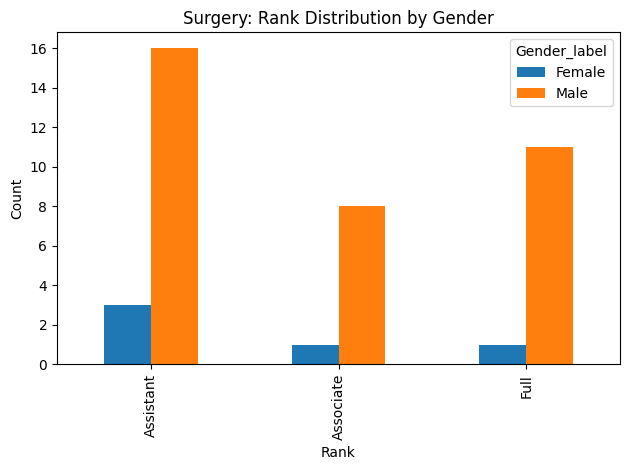

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_rank_by_gender.png


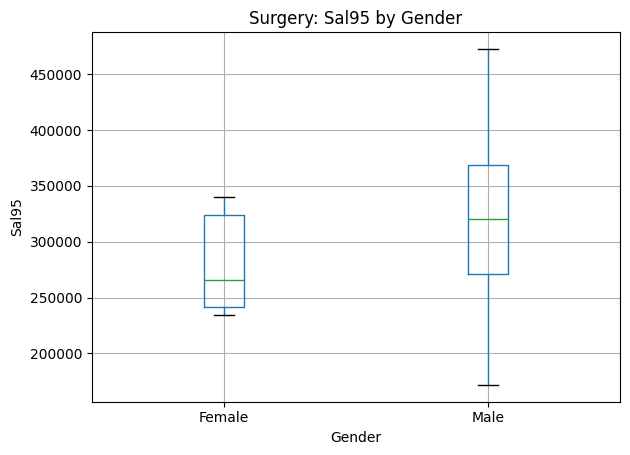

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_sal95_by_gender.png


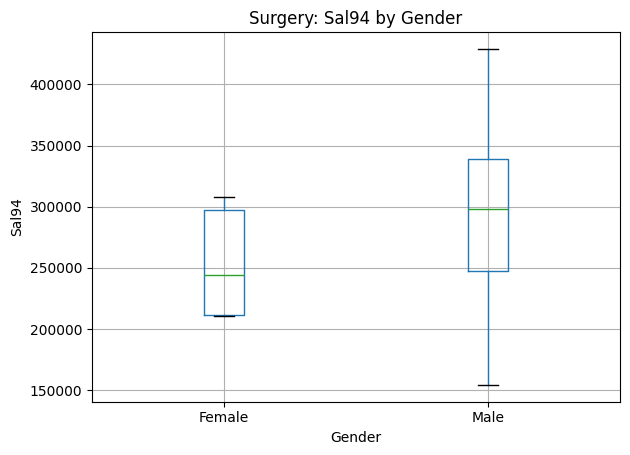

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_sal94_by_gender.png


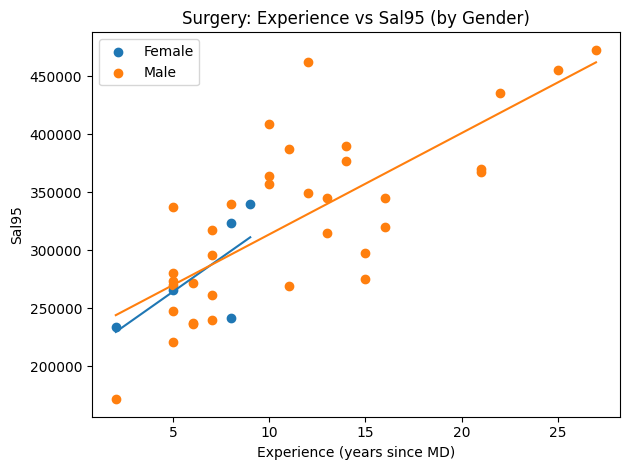

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_exper_vs_sal95.png


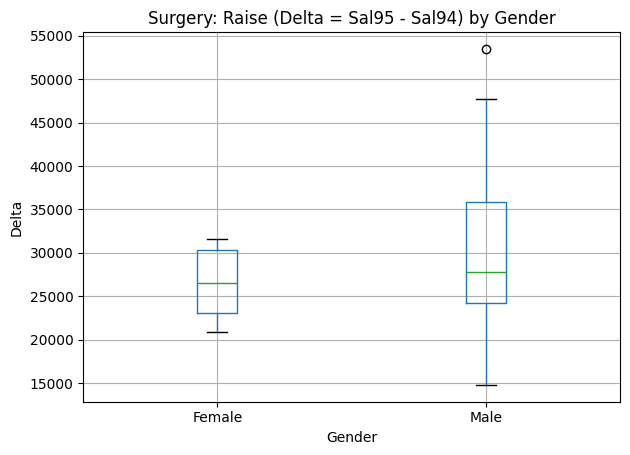

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_raise_delta_by_gender.png


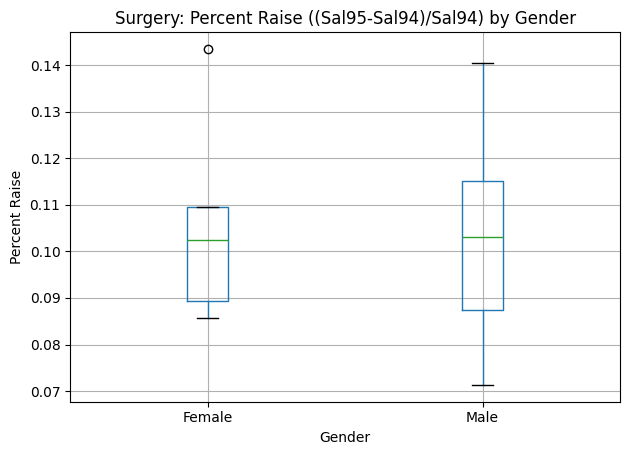

[Saved] c:\Users\Zhang\OneDrive - Nanyang Technological University\桌面\NTU学习\AN6003 Course Materials\AN6003 Course Materials\Graded Team Assignment - Gender Discrimination Lawsuit\AN6003_GradedTeamAssignment\outputs\surgery_raise_pct_by_gender.png


'c:\\Users\\Zhang\\OneDrive - Nanyang Technological University\\桌面\\NTU学习\\AN6003 Course Materials\\AN6003 Course Materials\\Graded Team Assignment - Gender Discrimination Lawsuit\\AN6003_GradedTeamAssignment\\outputs\\surgery_raise_pct_by_gender.png'

In [25]:
# ---------- 4.1 Rank distribution by Gender ----------
# Build the cross-tab here so this cell works even if the tests cell wasn't run
rank_map   = {1: "Assistant", 2: "Associate", 3: "Full"}
gender_map = {1: "Male", 0: "Female"}
if "Rank_label" not in surg.columns:
    surg["Rank_label"] = surg["Rank"].map(rank_map)
if "Gender_label" not in surg.columns:
    surg["Gender_label"] = surg["Gender"].map(gender_map)

rank_gender_table = (
    pd.crosstab(surg["Rank_label"], surg["Gender_label"])
      .reindex(["Assistant", "Associate", "Full"])   # keep logical rank order
      .fillna(0)
)

ax1 = rank_gender_table.plot(kind="bar")
fig1 = ax1.get_figure()
ax1.set_title("Surgery: Rank Distribution by Gender")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Count")
fig1.tight_layout()
plt.show()
save_fig(fig1, "surgery_rank_by_gender.png")   

# ---------- 4.2 Salary (Sal95) boxplot by Gender ----------
ax2 = surg.boxplot(column="Sal95", by="Gender_label")  
fig2 = ax2.get_figure()
ax2.set_title("Surgery: Sal95 by Gender")
fig2.suptitle("")                                    
ax2.set_xlabel("Gender")
ax2.set_ylabel("Sal95")
fig2.tight_layout()
plt.show()
save_fig(fig2, "surgery_sal95_by_gender.png")

# ---------- 4.3) Salary (Sal94) boxplot by Gender ----------
ax94 = surg.boxplot(column="Sal94", by="Gender_label")
fig94 = ax94.get_figure()
ax94.set_title("Surgery: Sal94 by Gender")
fig94.suptitle("")  
ax94.set_xlabel("Gender")
ax94.set_ylabel("Sal94")
fig94.tight_layout()
plt.show()
save_fig(fig94, "surgery_sal94_by_gender.png")

# ---------- 4.4 Experience vs Sal95 (scatter + OLS lines by gender) ----------
fig3 = plt.figure()
for g, gdf in surg.groupby("Gender_label"):
    plt.scatter(gdf["Exper"], gdf["Sal95"], label=g)
    if len(gdf) >= 2:
        slope, intercept, r, p, se = stats.linregress(gdf["Exper"], gdf["Sal95"])
        xs = np.linspace(gdf["Exper"].min(), gdf["Exper"].max(), 50)
        ys = intercept + slope*xs
        plt.plot(xs, ys)
plt.title("Surgery: Experience vs Sal95 (by Gender)")
plt.xlabel("Experience (years since MD)")
plt.ylabel("Sal95")
plt.legend()
plt.tight_layout()
plt.show()                                        
save_fig(fig3, "surgery_exper_vs_sal95.png")


# ---------- 4.5) Visualizing raise distributions by gender ----------
# --- Boxplot of absolute raise (Delta) by gender ---
axg1 = surg_growth.boxplot(column="Delta", by="Gender_label")
figg1 = axg1.get_figure()
axg1.set_title("Surgery: Raise (Delta = Sal95 - Sal94) by Gender")
figg1.suptitle("")
axg1.set_xlabel("Gender")
axg1.set_ylabel("Delta")
figg1.tight_layout()
plt.show()
save_fig(figg1, "surgery_raise_delta_by_gender.png")

# --- Boxplot of percent raise (Pct) by gender ---
surg_pct = surg_growth.dropna(subset=["Pct"])
axg2 = surg_pct.boxplot(column="Pct", by="Gender_label")
figg2 = axg2.get_figure()
axg2.set_title("Surgery: Percent Raise ((Sal95-Sal94)/Sal94) by Gender")
figg2.suptitle("")
axg2.set_xlabel("Gender")
axg2.set_ylabel("Percent Raise")
figg2.tight_layout()
plt.show()
save_fig(figg2, "surgery_raise_pct_by_gender.png")